##### Read Authdata

In [14]:
import twitter
import tweepy
import textblob

def getAuthData(fn):
    import csv
    with open('./authdata/'+fn, 'r') as f:
        reader = csv.reader(f)
        your_list = list(reader)

    authdata = {}   
    for element in your_list:
        authdata[element[0]] = element[1]

    return authdata

##### Get tweetdata - search term: hotel name

In [15]:
def getTweepyData(searchTerm, fileName):
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(OAUTH_TOKEN,OAUTH_TOKEN_SECRET)
    api = tweepy.API(auth)    
    
    tweet_cursor = tweepy.Cursor(api.search,q=searchTerm)
    
    tweetTexts = []
    n=0
    for tweet in tweet_cursor.items():    
        if n < 100:    
            tweetTexts.append(tweet.text) 
            n += 1
        else: 
            break
    #print (tweetTexts)
    with open("twitter/"+fileName,'w') as f:  
        f.writelines(tweetTexts)

In [16]:
import pandas as pd
for i in range(4):
    i = i+1
    authdata=getAuthData("authdata"+str(i)+".csv")

    CONSUMER_KEY = authdata['CONSUMER_KEY']
    CONSUMER_SECRET = authdata['CONSUMER_SECRET']
    OAUTH_TOKEN = authdata['OAUTH_TOKEN']
    OAUTH_TOKEN_SECRET = authdata['OAUTH_TOKEN_SECRET']
    
    myDF = pd.read_csv("hotel.csv")
    hotelList = [i.replace("/"," ") for i in myDF["name"]][(i-1)*40:i*40] 
    txtList = [i+".txt" for i in hotelList]

    for i in hotelList:
        getTweepyData(str(i),str(i)+".txt")    

##### Clean the data

In [17]:
def remove_punctuation(s):
    punctuation = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"
    s_sans_punct = ""
    for letter in s:
        if (letter not in punctuation) and (letter in "abcdefghijklmnopqrstuvwxyz "):
            s_sans_punct += letter
    return s_sans_punct
0
def getLowerCaseText(status_texts):
    lowered_texts = []
    for texts in status_texts:
        try: 
            mytext = str(texts.lower())
            lowered_texts.append(mytext)
        except:
            pass
    return lowered_texts

def removeStopwords(lowered_text):
    stopword=['he','she','is','and','the','to','of','it','in','you','or',"th"]
    remove_words=[]
    remove_text= [text for text in lowered_text if text not in stopword]
    remove_words.append(remove_text)
    
    return remove_words

def getCleanedTweets(remove_words):
    cleanedTweets = []
    for text in remove_words:
        wordlist = str(text).split()
        wordlist_nopun = [ str(remove_punctuation(for_a_word)) for for_a_word in wordlist ]
        cleanedTweets.append(wordlist_nopun)
    return cleanedTweets


def GetSentimentScores(cleanedTweets):
    sentiment = []
    for eachTweet in cleanedTweets:
        analysis = textblob.TextBlob(str(eachTweet))   
        sentiment.append(analysis.sentiment.polarity)
    return sentiment

##### Calculate the sentiment scores

In [18]:
import textblob
def getScore(fileName):    
    with open(fileName,'r') as f:
        tweetTexts = f.readlines()
    lowered_texts = getLowerCaseText(tweetTexts)   
    remove_texts = removeStopwords(lowered_texts)
    cleanedTweets = getCleanedTweets(remove_texts) 
    
    sentimentList = GetSentimentScores(cleanedTweets)

    score = sum(sentimentList)/len(sentimentList)
    return(score)
#getScore("twitter/Dream Downtown.txt")

In [19]:
hotelList = [i.replace("/"," ") for i in myDF["name"]][0:120] #######
txtList = [i+".txt" for i in hotelList]
scoreList = []

In [20]:
import csv
import pandas as pd
#scoreList = []
for i in txtList:
    score = "twitter/" + str(i) 
    scoreList.append(getScore(score))
print (len(scoreList))    

120


##### Sentiment score is from -1 to 1. Then transform rating to -1 to 1.

(0, 120)

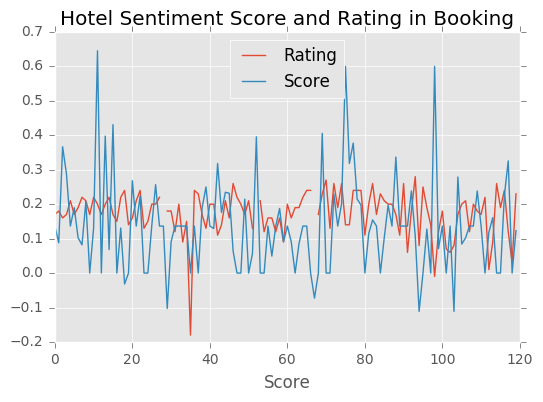

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot') 

ratingList = [(i-6.5)/10 for i in myDF['rating'][0:120]]   #######
#print (ratingList)
data = {"Score":scoreList[0:120],"Rating":ratingList}   #######

hotelList = [i.replace("/"," ") for i in myDF["name"]][0:120] ######

DF = pd.DataFrame(data,index=[i for i in range(len(hotelList))]) ###

#DF.plot(kind="barh")
DF.plot(kind="line")
plt.title("Hotel Sentiment Score and Rating in Booking")
plt.xlabel("Score")
#plt.xlim([0,120])
plt.xlim([0,120])

##### Linear regression: sentiment scores & rating

In [22]:
TXT = []
for txt in txtList:
    with open("twitter/"+txt,"r") as f:
        TXT.append(f.readlines())
with open("review.txt",'w') as fn:
    fn.write(str(TXT))

with open("review.txt",'r') as f:
    tweetTexts = f.readlines()        


lowered_texts = getLowerCaseText(tweetTexts)
remove_texts = removeStopwords(lowered_texts)
cleanedTweets = getCleanedTweets(remove_texts)

def cleanTEXT(cleanedTweets):
    import re
    t = str(cleanedTweets)
    p = re.compile('\w{3,}')
    txt = p.findall(t)

    with open("stopwords_en.txt","r") as f:
        sw = f.readlines()
        stopword = [n.strip() for n in sw]
        stopword.append("th")
    
    return ([i for i in txt if i not in stopword])

cleanTxt = cleanTEXT(cleanedTweets)
#print (cleanTxt)
with open("review_clean.txt","a") as f:
    for i in cleanTxt:
        f.write(i+' ')

In [61]:
import pandas as pd
mydf1 = pd.DataFrame({"score":scoreList[0:120],"rating":ratingList})  ##########
mydf1 = mydf1.dropna()
#print (mydf)
def regression():
    import numpy
    from sklearn import linear_model
    x1 = mydf1["score"]
    x1 = x1.tolist()
    y = mydf1["rating"]
    y = y.tolist()
    
    c = numpy.ones(len(x1))
    X = numpy.concatenate(([c],[x1]), axis=0).T

    model = linear_model.LinearRegression(fit_intercept = True)
    fit = model.fit(X,y)
    b = fit.coef_
    B = fit.intercept_
    
    print("Intercept : ",fit.intercept_)
    print("Slope : ", fit.coef_)

    from sklearn.metrics import r2_score
    pred = model.predict(X)
    r2 = r2_score(y,pred) 
    print ('R-squared: {:.6f}'.format(r2))

regression()    

Intercept :  0.172513502006
Slope :  [ 0.          0.01528994]
R-squared: 0.001054


##### Get twitter data - search term: hotel NYC and save then in txt file.

In [25]:
def getAuthData(fn):
    import csv
    with open('./authdata/'+fn, 'r') as f:
        reader = csv.reader(f)
        your_list = list(reader)

    authdata = {}   
    for element in your_list:
        authdata[element[0]] = element[1]
    return authdata

authdata=getAuthData("authdata5.csv")
CONSUMER_KEY = authdata['CONSUMER_KEY']
CONSUMER_SECRET = authdata['CONSUMER_SECRET']
OAUTH_TOKEN = authdata['OAUTH_TOKEN']
OAUTH_TOKEN_SECRET = authdata['OAUTH_TOKEN_SECRET']

In [26]:
def getTweepyData_Hotel(searchTerm, fileName):
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(OAUTH_TOKEN,OAUTH_TOKEN_SECRET)
    api = tweepy.API(auth)    
    
    tweet_cursor = tweepy.Cursor(api.search,q=searchTerm)
    
    tweetTexts = []
    n=0
    for tweet in tweet_cursor.items():    
        if n < 2000:    
            tweetTexts.append(tweet.text) 
            n += 1
        else: 
            break
    print (n)        
    #print (tweetTexts)
    with open(fileName,'w') as f:  
        f.writelines(tweetTexts)

In [27]:
getTweepyData_Hotel("hotel NYC", "wordcloud_hotel.txt")

2000


In [28]:
with open("wordcloud_hotel.txt",'r') as f:
    hotelTexts = f.readlines()        

hotelTexts = getLowerCaseText(hotelTexts)
hotelTexts = removeStopwords(hotelTexts)
hotelTexts = getCleanedTweets(hotelTexts)

def cleanTEXT(cleanedTweets):
    import re
    t = str(cleanedTweets)
    p = re.compile('\w{3,}')
    txt = p.findall(t)

    with open("stopwords_en.txt","r") as f:
        sw = f.readlines()
        stopword = [n.strip() for n in sw]
        stopword.append("th")
    
    return ([i for i in txt if i not in stopword])

cleanTxt = cleanTEXT(hotelTexts)
#print (cleanTxt)
with open("wordcloud_hotel_clean.txt","a") as f:
    for i in cleanTxt:
        f.write(i+' ')